# Action Recognition

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import files
uploaded = files.upload()

In [ ]:
import csv
import shutil

mainPath = '/content/drive/MyDrive/AIIntro/[processed]dream_picture/'

jpgCount = 0

with open(mainPath + 'Classification.csv', newline='') as csvfile:
    rows = csv.reader(csvfile)

    for row in rows:
        jpgCount += 1
        if row[0]=='0':
            continue
        sourcePath = mainPath + '20200610-20200620-camera-3/tuning_photos/Sharpen_0p3_Add_5/crop_with_FasterRCNN/' + str(jpgCount) + '.jpg'
        targetPath = ''

        if row[0]=='1':
            targetPath = mainPath + 'Action_Recognition/1_using_computers/' + str(jpgCount) + '.jpg'
        elif row[0]=='2':
            targetPath = mainPath + 'Action_Recognition/2_studying/' + str(jpgCount) + '.jpg'
        elif row[0]=='3':
            targetPath = mainPath + 'Action_Recognition/3_sleeping/' + str(jpgCount) + '.jpg'
        elif row[0]=='4':
            targetPath = mainPath + 'Action_Recognition/4_using_smartphones/' + str(jpgCount) + '.jpg'
        
        shutil.copy(sourcePath, targetPath)
        print(jpgCount)

In [ ]:
!ls
!nvidia-smi

drive  sample_data
Mon Dec 28 11:55:00 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.27.04    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P0    32W /  70W |   2207MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                     

In [ ]:
import os, torch, torchvision, random
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from PIL import Image

import torch.nn.functional as F
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import Dataset, random_split, DataLoader
from torchvision.datasets import ImageFolder
from torchvision import models
from torch import optim
from torchsummary import summary

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
  print('cuda')

cuda


### Setting

依據需求調整參數

In [ ]:
serialString = '20201228_12'
pretrained = 'yes'
model = 'VGG16_bn'
batch_size = 32
lr = 5e-4
epochs = 180
inputSize = 128
lossFunction = 'CrossEntropyLoss'
optimizer = 'SGD'

data_dir = '/content/drive/MyDrive/AIIntro/[processed]dream_picture/Action_Recognition/'
resultPath = '/content/drive/MyDrive/AIIntro/[processed]dream_picture/Action_Recognition_Result/' + serialString + '/'
if os.path.exists(resultPath) == False:
    os.makedirs(resultPath)

net = models.vgg16_bn(pretrained = True if pretrained == 'yes' else False)

C = net.to(device)
optimizer_C = optim.SGD(C.parameters(), lr = lr, momentum = 0.9) # 選擇你想用的 optimizer

# Loss function
criterion = nn.CrossEntropyLoss() # 選擇想用的 loss function

Downloading: "https://download.pytorch.org/models/vgg16_bn-6c64b313.pth" to /root/.cache/torch/hub/checkpoints/vgg16_bn-6c64b313.pth


### Part 1：Dataloader 實作

In [ ]:
# 1.1. 填入 ??? 的部份

'''class DogDataset(Dataset):
    
    def __init__(self, filenames, labels, transform):
        
        self.filenames = filenames # 資料集的所有檔名
        self.labels = labels # 影像的標籤
        self.transform = transform # 影像的轉換方式
 
    def __len__(self):
        
        return len(self.filenames) # return DataSet 長度
 
    def __getitem__(self, idx):
        
        image = Image.open(self.filenames[idx]).convert('RGB')
        image = self.transform(image) # Transform image
        label = np.array(self.labels[idx]) # why np?
        # label = self.labels[idx]
                
        return image, label # return 模型訓練所需的資訊'''
class ActionDataset(Dataset):
    
    def __init__(self, filenames, labels, transform):
        
        self.filenames = filenames # 資料集的所有檔名
        self.labels = labels # 影像的標籤
        self.transform = transform # 影像的轉換方式
 
    def __len__(self):
        
        return len(self.filenames) # return DataSet 長度
 
    def __getitem__(self, idx):
        
        image = Image.open(self.filenames[idx]).convert('RGB')
        image = self.transform(image) # Transform image

        # label = np.array(self.labels[idx]) # why np?
        label = self.labels[idx]

        # CAN I ADD FILENAME TO THIS LINE?
        return image, label # return 模型訓練所需的資訊


In [ ]:
normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225])

# Transformer
'''train_transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(inputSize),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])'''
train_transformer = transforms.Compose([
    transforms.Resize(160),
    transforms.RandomResizedCrop(inputSize),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])

'''test_transformer = transforms.Compose([
    transforms.Resize(inputSize),
    transforms.CenterCrop(inputSize),
    transforms.ToTensor(),
    normalize
])'''
test_transformer = transforms.Compose([
    transforms.Resize(inputSize),
    transforms.CenterCrop(inputSize),
    transforms.ToTensor(),
    normalize
])

# 1.2. 填入 ??? 的部份

def split_Train_Val_Data(data_dir):
    
    dataset = ImageFolder(data_dir) 
    
    # 建立 20 類的 list
    character = [[] for i in range(len(dataset.classes))]
    # print(character)
    
    # 將每一類的檔名依序存入相對應的 list
    for x, y in dataset.samples: # x: path, y: index
        character[y].append(x)
      
    train_inputs, test_inputs = [], []
    train_labels, test_labels = [], []
    
    for i, data in enumerate(character): # 讀取每個類別中所有的檔名 (i: label, data: filename)
        
        np.random.seed(42)
        np.random.shuffle(data) # 先做一次shuffle
            
        # -------------------------------------------
        # 將每一類都以 8:2 的比例分成訓練資料和測試資料
        # -------------------------------------------
        
        num_sample_train = int(len(data)*0.8)
        num_sample_test = len(data) - num_sample_train
        
        # print(str(i) + ': ' + str(len(data)) + ' | ' + str(num_sample_train) + ' | ' + str(num_sample_test))
        
        for x in data[0:num_sample_train] : # 前 80% 資料存進 training list
            train_inputs.append(x)
            train_labels.append(i)
            
        for x in data[num_sample_train:(num_sample_train+num_sample_test)] : # 後 20% 資料存進 testing list
            test_inputs.append(x)
            test_labels.append(i)

    # train_dataloader = DataLoader(DogDataset(train_inputs, train_labels, train_transformer),
    #                               batch_size = batch_size, shuffle = True)
    train_dataloader = DataLoader(ActionDataset(train_inputs, train_labels, train_transformer),
                                  batch_size = batch_size, shuffle = True)
    # test_dataloader = DataLoader(DogDataset(test_inputs, test_labels, test_transformer),
    #                               batch_size = batch_size, shuffle = False)
    test_dataloader = DataLoader(ActionDataset(test_inputs, test_labels, test_transformer),
                                  batch_size = batch_size, shuffle = False)
 
    return train_dataloader, test_dataloader

### Part 2: 建立 CNN Model

In [ ]:
# 2.2. 自行設計一個新的 CNN model

'''class BuildModel(nn.Module):

    def __init__(self):
        
        super(BuildModel, self).__init__()
        
        # ----------------------------------------------
        ??? # 初始化模型的 layer (input size: 3 * 224 * 224)
        # ----------------------------------------------
               
    def forward(self, x):
        
        # ----------------------------------------------
        ??? # Forward (最後輸出 20 個類別的機率值)
        # ----------------------------------------------
        return ???'''

'class BuildModel(nn.Module):\n\n    def __init__(self):\n        \n        super(BuildModel, self).__init__()\n        \n        # ----------------------------------------------\n        ??? # 初始化模型的 layer (input size: 3 * 224 * 224)\n        # ----------------------------------------------\n               \n    def forward(self, x):\n        \n        # ----------------------------------------------\n        ??? # Forward (最後輸出 20 個類別的機率值)\n        # ----------------------------------------------\n        return ???'

In [ ]:
train_dataloader, test_dataloader = split_Train_Val_Data(data_dir)

# summary(net, (3, 128, 128)) # 利用 torchsummary 的 summary package 印出模型資訊

In [ ]:
loss_epoch_C = []
train_acc, test_acc = [], []
best_acc, best_auc = 0.0, 0.0

### 3. 實作模型訓練和測試模型效能

In [ ]:
if __name__ == '__main__':    
    for epoch in range(epochs):
    
        iter = 0
        correct_train, total_train = 0, 0
        correct_test, total_test = 0, 0
        train_loss_C = 0.0

        C.train() # 設定 train 或 eval
      
        print('epoch: ' + str(epoch + 1) + ' / ' + str(epochs))  
        
        # ---------------------------
        # Training Stage
        # ---------------------------
        
        for i, (x, label) in enumerate(train_dataloader) :
                     
            x, label = x.to(device), label.to(device)
                        
            optimizer_C.zero_grad() # 清空梯度
            
            output = C(x) # 將訓練資料輸入至模型進行訓練
            # output, omit = C(x) # for inception v3
            loss = criterion(output, label) # 計算 loss

            loss.backward() # 將 loss 反向傳播
            optimizer_C.step() # 更新權重
            
            # 計算訓練資料的準確度 (correct_train / total_train)
            _, predicted = torch.max(output.data, 1)
            total_train += batch_size
            correct_train += (predicted==label).sum().item()

            train_loss_C += loss.item()
            iter += 1
                    
        print('Training epoch: %d / loss_C: %.3f | acc: %.3f' % \
              (epoch + 1, train_loss_C / iter, correct_train / total_train))

        
        # --------------------------
        # Testing Stage
        # --------------------------
        
        C.eval() # 設定 train 或 eval
          
        for i, (x, label) in enumerate(test_dataloader) :
          
            # 測試階段不需要求梯度
            with torch.no_grad():
                x, label = x.to(device), label.to(device)

                # 將測試資料輸入至模型進行測試
                output = C(x)
                
                # 計算測試資料的準確度
                _, predicted = torch.max(output.data, 1)
                total_test += batch_size
                correct_test += (predicted == label).sum().item()
        
        print('Testing acc: %.3f' % (correct_test / total_test))
                                     
        train_acc.append(100 * correct_train / total_train) # training accuracy
        test_acc.append(100 * correct_test / total_test)  # testing accuracy
        loss_epoch_C.append(train_loss_C/iter) # loss 

        if (correct_test/total_test) > 0.68:
            modelPath = resultPath + 'model_GPU_acc=' + str(correct_test/total_test) + '.pt'
            torch.save(C.state_dict(), modelPath)

epoch: 1 / 180
Training epoch: 1 / loss_C: 5.990 | acc: 0.128
Testing acc: 0.406
epoch: 2 / 180
Training epoch: 2 / loss_C: 1.547 | acc: 0.418
Testing acc: 0.438
epoch: 3 / 180
Training epoch: 3 / loss_C: 1.348 | acc: 0.431
Testing acc: 0.469
epoch: 4 / 180
Training epoch: 4 / loss_C: 1.247 | acc: 0.446
Testing acc: 0.484
epoch: 5 / 180
Training epoch: 5 / loss_C: 1.166 | acc: 0.478
Testing acc: 0.490
epoch: 6 / 180
Training epoch: 6 / loss_C: 1.089 | acc: 0.534
Testing acc: 0.526
epoch: 7 / 180
Training epoch: 7 / loss_C: 1.063 | acc: 0.534
Testing acc: 0.536
epoch: 8 / 180
Training epoch: 8 / loss_C: 1.048 | acc: 0.554
Testing acc: 0.526
epoch: 9 / 180
Training epoch: 9 / loss_C: 0.947 | acc: 0.580
Testing acc: 0.547
epoch: 10 / 180
Training epoch: 10 / loss_C: 0.959 | acc: 0.584
Testing acc: 0.526
epoch: 11 / 180
Training epoch: 11 / loss_C: 0.925 | acc: 0.618
Testing acc: 0.521
epoch: 12 / 180
Training epoch: 12 / loss_C: 0.868 | acc: 0.628
Testing acc: 0.536
epoch: 13 / 180
Traini

### 4. 將每一個 epoch 的 Loss 以及 Training / Testing accuracy 紀錄下來並繪製成圖。

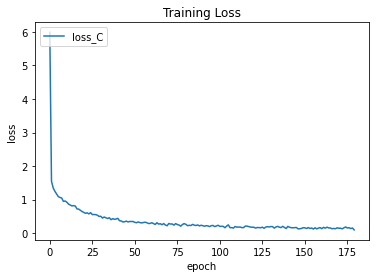

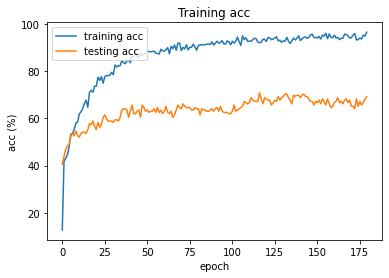

In [ ]:
plt.figure()

plt.plot(loss_epoch_C) # plot your loss

plt.title('Training Loss')
plt.ylabel('loss'), plt.xlabel('epoch')
plt.legend(['loss_C'], loc = 'upper left')
plt.savefig(resultPath + 'Loss.png')
plt.show()

plt.figure()

plt.plot(train_acc) # plot your training accuracy
plt.plot(test_acc) # plot your testing accuracy

plt.title('Training acc')
plt.ylabel('acc (%)'), plt.xlabel('epoch')
plt.legend(['training acc', 'testing acc'], loc = 'upper left')
plt.savefig(resultPath + 'Accuracy.png')
plt.show()

###5. 儲存訓練結果

In [ ]:
import gdown
url = 'https://drive.google.com/uc?export=download&id=170CjxBy-5nkoCmVzkoSfOXcGxZ-ZqwET'
output = resultPath + 'training_result.json'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?export=download&id=170CjxBy-5nkoCmVzkoSfOXcGxZ-ZqwET
To: /content/drive/MyDrive/AIIntro/[processed]dream_picture/Action_Recognition_Result/20201228_12/training_result.json
0.00B [00:00, ?B/s]


'/content/drive/MyDrive/AIIntro/[processed]dream_picture/Action_Recognition_Result/20201228_12/training_result.json'

In [ ]:
import json

dictionary = {
    "serial_string": serialString,
    "model": model,
    "pretrained": pretrained,
    "batch_size": batch_size,
    "lr": lr,
    "epochs": epochs,
    "input_size": inputSize,
    "loss_function": lossFunction,
    "optimizer": optimizer,
    "best_train_accuracy": max(train_acc),
    "best_test_accuracy": max(test_acc)
}

jsonDump = json.dumps(dictionary, indent=4)
with open(resultPath + 'training_result.json', 'w') as outfile:
  outfile.write(jsonDump)
print('\n\ncheck result file saved successfully!')



check result file saved successfully!
